# Probabilistic Reasoning and Graphical Models

Complete all work in this notebook in the text and code cells provided, and as instructed. When you're ready to turn the notebook with your answers in for grading, Use the File menu to Download it as an `.ipynb` file. Submit that file as an attachment in Canvas.

Note: the output of the code you run in the notebook will not be saved with it, so make sure that your answers are captured in code cells or text cells.


Consider the Bayesian network for respiratory illness depicted in the figure below (source: Radboud Universiteit, Netherlands). There are five random variables, all binary (four are "yes/no" and one is "above/below" a temperature threshold).  The figure depicts the prior probabilities or conditional probability tables (CPTs) for each variable.

a. Encode this network using the `pgmpy` package. Here's the [home page](https://pgmpy.org/) for `pgmpy`.  There are example notebooks available, and the documentation is reasonably detailed. Focus on the "discrete Bayesian networks" material.
 + Put all your `imports` in the first code cell below.
 + **It is easy to bog down in the fiddly details here. Use good debugging techniques and ask questions if you're struggling with anything.**
 + Your network must be named `resp_model`.
 + To create the model, you supply the edge list to its constructor, _i.e._ `resp_model = BayesianNetwork(edge_list)` will create the object.
 + Use the abbreviations (FL, PN, MY, FE, TEMP) for the node names in the edge specifications.
 + Install the CPTs into the nodes.
  + For all nodes except TEMP, use ['No','Yes'] for the `state_names`. For TEMP, use ['Low','High'].
  + If your node has no parent, use the CPT to specify the prior (only the `variable`, `variable_card`, `values`, and `state_names` need to be supplied)
  + If your node has parents, use the CPT to specify the full conditional probability specification -- you'll need to use `variable`, `variable_card`, `values`, `evidence`, `evidence_card`, and `state_names`.
 + Once your network is created, use `.check_model()`. If it returns `False`, you have a bug and you must fix it.
 + In a separate cell, print out all of the CPTs you installed (for prior and conditional probabilities) and look at them and the figure to ensure that you have the right numbers in the right places.  The graders will want to see those printouts, so even after squasing the bugs, leave that code enabled.

b. Query the network as follows.
 + In a separate cell, create a solver named `resp_infer` by wrapping your `resp_model` network in `VariableElimination()`, _i.e._ `resp_infer = VariableElimination(resp_model)`.
 + In a separate cell, loop over each variable and distinct pair of variables in the network and print out their marginal probabilities. Use the `.query()` method to do this.
 + In a separate cell, write the code needed to answer these two questions. Suppose a patient presents with fever and elevated temperature - what's the posterior probability of flu? of pneumonia?
 + In a separate cell, write the code needed to answer these two questions. Suppose a patient presents with fever and elevated temperature, but without myalgia - what's the posterior probability of flu? Of pneumonia?


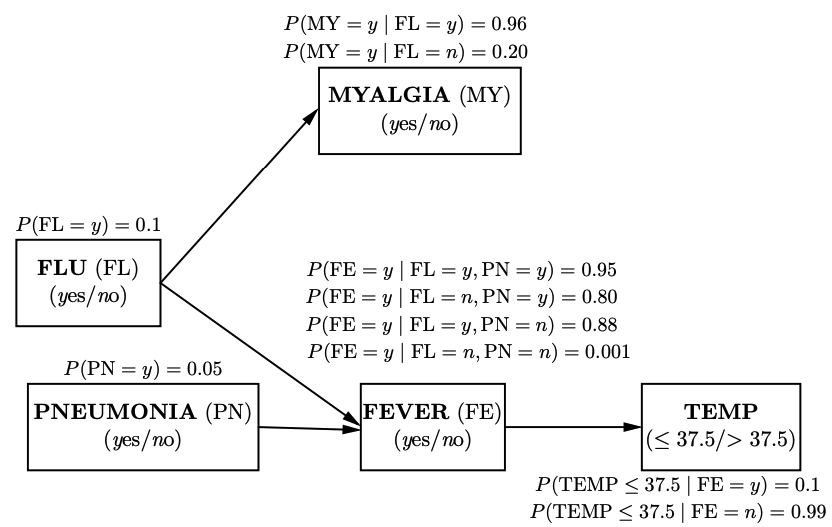



In [ ]:
# import all the things
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

In [ ]:
# States
YN = ['No', 'Yes']
HL = ['Low', 'High']

# Create DAG Edge list
edge_list = [
    ('PN', 'FE'),
    ('FL', 'FE'),
    ('FE', 'TEMP'),
    ('FL', 'MY')
]

# Create the model
resp_model = BayesianNetwork(edge_list)

# Install priors into the nodes
cpd_PN = TabularCPD(
    variable = 'PN',
    variable_card = 2,
    values = [[0.95],[0.05]],
    state_names = {'PN': YN}
)

cpd_FL = TabularCPD(
    variable = 'FL',
    variable_card = 2,
    values = [[0.9],[0.1]],
    state_names = {'FL': YN}
)

# Install conditional probabilities
cpd_FE = TabularCPD(
    variable = 'FE',
    variable_card = 2,
    evidence = ['FL', 'PN'],
    evidence_card = [2, 2],
    state_names = {'FE': YN, 'FL': YN, 'PN': YN},
    values = [[0.999, 0.2, 0.12, 0.05], [0.001, 0.8, 0.88, 0.95]],
)

cpd_MY = TabularCPD(
    variable = 'MY',
    variable_card = 2,
    evidence = ['FL'],
    evidence_card = [2],
    state_names = {'MY': YN, 'FL': YN},
    values = [[0.8, 0.04], [0.2, 0.96]],
)

cpd_TEMP = TabularCPD(
    variable = 'TEMP',
    variable_card = 2,
    evidence = ['FE'],
    evidence_card = [2],
    state_names = {'TEMP': HL, 'FE': YN},
    values = [[0.99, 0.1], [0.01, 0.9]],
)

# Add CPDs to model
resp_model.add_cpds(cpd_PN,
                    cpd_FL,
                    cpd_FE,
                    cpd_MY,
                    cpd_TEMP)

# Check sanity
try:
    print(resp_model.check_model())
    print('Model check succeeded.')
except Exception as e:
    print(f"check_model failed: {e}")


In [ ]:
# All the CPTs installed
print("Pneumonia")
print(cpd_PN)
print()

print("Flu")
print(cpd_FL)
print()

print("Fever")
print(cpd_FE)
print()

print("Myalgia")
print(cpd_MY)
print()

print("Temperature")
print(cpd_TEMP)

In [ ]:
# Create solver
resp_infer = VariableElimination(resp_model)

In [ ]:
# Nodes
nodes = ['PN', 'FL', 'FE', 'MY', 'TEMP']
visited = []

for node in nodes:
  print(resp_infer.query([node]))

  for other in nodes:
    if node != other and [node, other] not in visited and [other, node] not in visited:
      print(resp_infer.query([node, other]))
      visited.append([node,other])

q = resp_infer.query(['PN', 'FL', 'FE', 'MY', 'TEMP'])
print()
print(q)

In [ ]:
# Suppose a patient presents with fever and elevated temperature.
# What's the posterior probability of flu? of pneumonia?

# For Flu
print(resp_infer.query(['FL'], evidence={'FE': 'Yes', 'TEMP': 'High'}))
print('The probability is shown in the table above in the FL(Yes) entry.')
print()

# For Pneumonia
print(resp_infer.query(['PN'], evidence={'FE': 'Yes', 'TEMP': 'High'}))
print('The probability is shown in the table above in the PN(Yes) entry.')
print()


In [ ]:
# Suppose a patient presents with fever and elevated temperature, but without myalgia - what's the posterior probability of flu? Of pneumonia?

# For Flu
print(resp_infer.query(['FL'], evidence={'FE': 'Yes', 'TEMP': 'High', 'MY': 'No'}))
print('The probability is shown in the table above in the FL(Yes) entry.')
print()

# For Pneumonia
print(resp_infer.query(['PN'], evidence={'FE': 'Yes', 'TEMP': 'High', 'MY': 'No'}))
print('The probability is shown in the table above in the PN(Yes) entry.')
print()